<a href="https://colab.research.google.com/github/YS-JEOUNG/amazon-review-project/blob/main/code/artscrafts_code/artscrafts_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
# dataframe
import pandas as pd

# array
import numpy as np
import itertools

# decompress the file
import gzip

# visualizations
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.colors as colors
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

# datetime
from datetime import datetime

# text preprocessing
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize.toktok import ToktokTokenizer
import gensim
import re

import unicodedata
tokenizer = ToktokTokenizer()
nlp = spacy.load('en', parse=True, tag=True, entity=True)

In [ ]:
# modeling
from sklearn.model_selection import cross_validate, train_test_split, StratifiedKFold, GridSearchCV, cross_val_predict, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, GaussianNB
!pip install catboost
import catboost
from catboost import CatBoostClassifier, Pool
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, f1_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from gensim.models import Word2Vec
from tqdm import tqdm
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

# warnings
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project/arts_tokenized.csv')
df.head()

,overall,vote,verified,reviewer_id,asin,style,reviewer_name,unix_review_time,category,description,title,brand,rank,main_cat,price,review_text,rating_class,time,clean_text,token,review_length,review_length_bin,rating_class_num
0,5.0,9,True,APVFJYDRTYNK5,886293162X,{'Format:': ' Paperback'},Mrs. Sally L. C. Marsh,1290816000,"['Arts, Crafts & Sewing', 'Crafting', 'Paper &...",['The new Volant Address Book has ruled pages ...,"Moleskine Volant Address Book, Large, Magenta,...",Moleskine,"['>#514,989 in Office Products (See top 100)',...",Office Products,NaN,"Nice and perfect for an address book Thin, you...",good,2010-11-27,nice perfect address book thin could slide dra...,"['nice', 'perfect', 'address', 'book', 'thin',...",55,"(0.0, 100.0]",1
1,4.0,69,True,A3BQSWC3801JNI,8862933177,{'Format:': ' Hardcover'},Stacy A. Jones,1267660800,"['Arts, Crafts & Sewing', 'Crafting', 'Paper &...",['Build your very own film archive. Fully embo...,"Moleskine Passion Journal - Film, Large, Hard ...",Moleskine,"['>#229,441 in Office Products (See top 100)',...",Office Products,$137.58,"Solid buy, few small gripes about page layout ...",good,2010-03-04,solid buy small grip page layout honest alread...,"['solid', 'buy', 'small', 'grip', 'page', 'lay...",367,"(300.0, 400.0]",1
2,5.0,5,True,A1RY2FJR0TVP85,8862933177,{'Format:': ' Hardcover'},N. M. Patterson,1267056000,"['Arts, Crafts & Sewing', 'Crafting', 'Paper &...",['Build your very own film archive. Fully embo...,"Moleskine Passion Journal - Film, Large, Hard ...",Moleskine,"['>#229,441 in Office Products (See top 100)',...",Office Products,$137.58,Cool place to Catalog Your Recipes I purchased...,good,2010-02-25,cool place catalog recipes purchase recipe jou...,"['cool', 'place', 'catalog', 'recipes', 'purch...",142,"(100.0, 200.0]",1
3,2.0,2,True,A12GULZW3W4W3P,8862933177,{'Format:': ' Hardcover'},Jazz,1499299200,"['Arts, Crafts & Sewing', 'Crafting', 'Paper &...",['Build your very own film archive. Fully embo...,"Moleskine Passion Journal - Film, Large, Hard ...",Moleskine,"['>#229,441 in Office Products (See top 100)',...",Office Products,$137.58,Its ok read for specifications I did not like ...,bad,2017-07-06,ok read specifications not like really like mo...,"['ok', 'read', 'specifications', 'not', 'like'...",226,"(200.0, 300.0]",0
4,5.0,2,True,A2G1BD6F2WR4YW,8862933177,{'Format:': ' Hardcover'},rrobey619,1498003200,"['Arts, Crafts & Sewing', 'Crafting', 'Paper &...",['Build your very own film archive. Fully embo...,"Moleskine Passion Journal - Film, Large, Hard ...",Moleskine,"['>#229,441 in Office Products (See top 100)',...",Office Products,$137.58,Great for Chefs. I'm a chef and I was looking ...,good,2017-06-21,great chefs chef look book jot quick ideas ins...,"['great', 'chefs', 'chef', 'look', 'book', 'jo...",44,"(0.0, 100.0]",1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130133 entries, 0 to 130132
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   overall            130133 non-null  float64
 1   vote               130133 non-null  int64  
 2   verified           130133 non-null  bool   
 3   reviewer_id        130133 non-null  object 
 4   asin               130133 non-null  object 
 5   style              130133 non-null  object 
 6   reviewer_name      130128 non-null  object 
 7   unix_review_time   130133 non-null  int64  
 8   category           130133 non-null  object 
 9   description        130133 non-null  object 
 10  title              130133 non-null  object 
 11  brand              129770 non-null  object 
 12  rank               130133 non-null  object 
 13  main_cat           129791 non-null  object 
 14  price              115105 non-null  object 
 15  review_text        130133 non-null  object 
 16  ra

In [ ]:
df_use = df.drop(['overall', 'vote', 'verified', 'style', 'reviewer_name', 'unix_review_time', 'category', 'description', 'title',
                  'brand', 'rank', 'main_cat', 'price', 'time', 'review_length', 'review_length_bin', 'rating_class_num'], axis=1)
df_use.head()

,reviewer_id,asin,review_text,rating_class,clean_text,token
0,APVFJYDRTYNK5,886293162X,"Nice and perfect for an address book Thin, you...",good,nice perfect address book thin could slide dra...,"['nice', 'perfect', 'address', 'book', 'thin',..."
1,A3BQSWC3801JNI,8862933177,"Solid buy, few small gripes about page layout ...",good,solid buy small grip page layout honest alread...,"['solid', 'buy', 'small', 'grip', 'page', 'lay..."
2,A1RY2FJR0TVP85,8862933177,Cool place to Catalog Your Recipes I purchased...,good,cool place catalog recipes purchase recipe jou...,"['cool', 'place', 'catalog', 'recipes', 'purch..."
3,A12GULZW3W4W3P,8862933177,Its ok read for specifications I did not like ...,bad,ok read specifications not like really like mo...,"['ok', 'read', 'specifications', 'not', 'like'..."
4,A2G1BD6F2WR4YW,8862933177,Great for Chefs. I'm a chef and I was looking ...,good,great chefs chef look book jot quick ideas ins...,"['great', 'chefs', 'chef', 'look', 'book', 'jo..."


In [ ]:
df_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130133 entries, 0 to 130132
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   reviewer_id   130133 non-null  object
 1   asin          130133 non-null  object
 2   review_text   130133 non-null  object
 3   rating_class  130133 non-null  object
 4   clean_text    130133 non-null  object
 5   token         130133 non-null  object
dtypes: object(6)
memory usage: 6.0+ MB


# Natural Language Processing

## Data Preprocessing

In [ ]:
# separate response variable and feature
df_use['rating_class'] = df_use['rating_class'].apply(lambda x:0 if x == 'bad' else 1)

In [ ]:
# split the dataset into train and test sets
# 전체 데이터셋으로 하려니 코랩이 죽어서 일단 슬라이싱 해서 시도해보겠음
X = df_use['clean_text'][:10000]
y = df_use['rating_class'][:10000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape

((7500,), (2500,))

# Confusion Matrix Plot Function

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.ocean):
    """
    Create a confusion matrix plot for 'good' and 'bad' rating values
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt='.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center',
                 color='white' if cm[i, j] < thresh else 'black', fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('true label', fontsize=30)
    plt.xlabel('predicted label', fontsize=30)

    return plt

In [ ]:
def disp_confusion_matrix(y_pred, model_name, vector='CounterVectorizing'):
    """
    Display confusion matrix for selected model with countVectorizer
    """
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(10, 10))
    plot = plot_confusion_matrix(cm, classes=['Bad', 'Good'], normalize=False,
                                 title=model_name+" "+'with'+" "+vector+" "+'\nConfusion Matrix')
    plt.show()

# Modeling

## CountVectorizer Bag of Words

In [ ]:
# Create the word vector with CountVectorizer
count_vect = CountVectorizer(ngram_range=(1, 1))
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()

In [ ]:
# Print vocabulary length
print('vocabulary length:', len(count_vect.get_feature_names()))

vocabulary length: 14919


In [ ]:
# Assign feature names of vector into a variable
vocab = count_vect.get_feature_names()

# Dataframe for train countvectorizer dataset
pd.DataFrame(count_vect_train, columns=vocab).head()

,__________________,aa,aaahhhing,aaalways,aamco,aas,abandon,abbott,abbys,abide,abilities,ability,abilty,able,abnormally,abosolutely,abrasion,abrasions,abrasive,abrir,abroad,absence,absolute,absolutely,absolutly,absorb,absorba,absorbancy,absorbency,absorbent,absorbentmarkable,absorber,abstenance,abstract,abstractimpressionist,absurd,abundance,abundantly,abuse,abut,...,youtubing,youve,yr,yrds,yro,yrold,yrs,yry,yuck,yucky,yum,yummy,yup,yupo,zag,zealand,zebra,zelda,zen,zero,zig,zigzag,zigzig,zillion,zinc,zing,zinnia,zip,zipcon,ziploc,ziplock,zipper,zippy,zombie,zombies,zombify,zone,zoom,zyron,zz
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Create a function for applying different algorithms
def modeling(Model, Xtrain=count_vect_train, Xtest=count_vect_test):
    """
    This function apply countVectorizer with machine learning algorithms.
    """
    # instantiate the classifier: model
    model = Model

    # fit classifier to the training set(all features)
    model.fit(Xtrain, y_train)

    global y_pred
    # predicting the test set results
    y_pred = model.predict(Xtest)

    # assign f1 score to a variable
    score = f1_score(y_test, y_pred, average='weighted')

    # print evaluation metric(f1-score)
    print(f'f1 score: {score}')

In [ ]:
# dummy classifier
clf = DummyClassifier(strategy='stratified', random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = f1_score(y_test, y_pred, average='weighted')

# print evaluation metric(f1-score)
print(f'f1 score: {score}')

f1 score: 0.6703325148040813


In [ ]:
# compute and print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.23      0.24      0.24       538
           1       0.79      0.79      0.79      1962

    accuracy                           0.67      2500
   macro avg       0.51      0.51      0.51      2500
weighted avg       0.67      0.67      0.67      2500



### Logistic Regression with CountVectorizer

In [ ]:
# call the modeling function for logistic regression with countvectorizer and print f1 score
modeling(LogisticRegression(multi_class='multinomial', solver='newton-cg',
                            class_weight='balanced', C=0.1, n_jobs=-1, random_state=42))

# assign y_pred to a variable for further process
y_pred_cv_logreg = y_pred

f1 score: 0.8850839780997816


In [ ]:
# classification report
print(classification_report(y_test, y_pred_cv_logreg))

              precision    recall  f1-score   support

           0       0.69      0.83      0.75       538
           1       0.95      0.90      0.92      1962

    accuracy                           0.88      2500
   macro avg       0.82      0.86      0.84      2500
weighted avg       0.89      0.88      0.89      2500



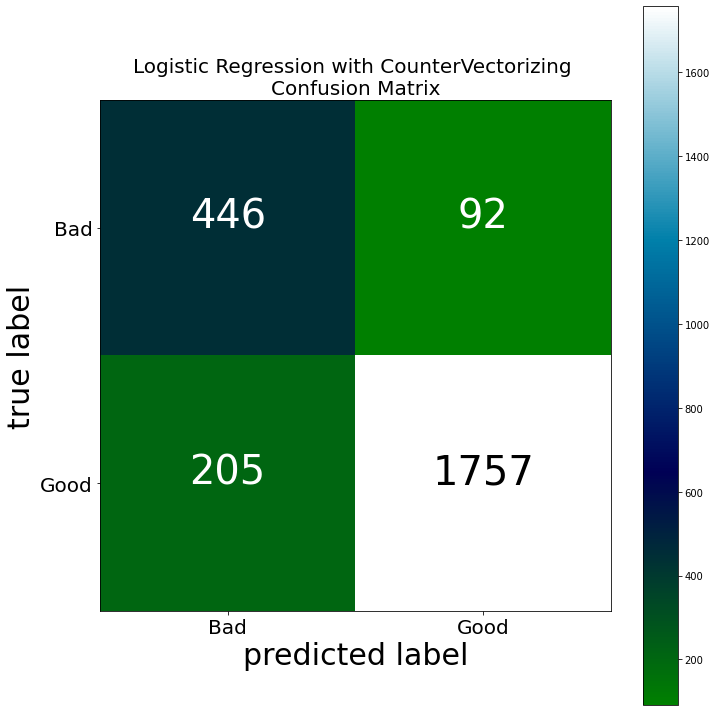

In [ ]:
# confusion matrix
disp_confusion_matrix(y_pred_cv_logreg, 'Logistic Regression')

### Random Forest with CountVectorizer

In [ ]:
# modeling function for random forest classifier with countvectorizer and print f1 score
modeling(RandomForestClassifier(n_estimators=200, random_state=42))

y_pred_cv_rf = y_pred

f1 score: 0.8581277960099915


In [ ]:
# classification report
print(classification_report(y_test, y_pred_cv_rf))

              precision    recall  f1-score   support

           0       0.92      0.46      0.61       538
           1       0.87      0.99      0.93      1962

    accuracy                           0.87      2500
   macro avg       0.89      0.72      0.77      2500
weighted avg       0.88      0.87      0.86      2500



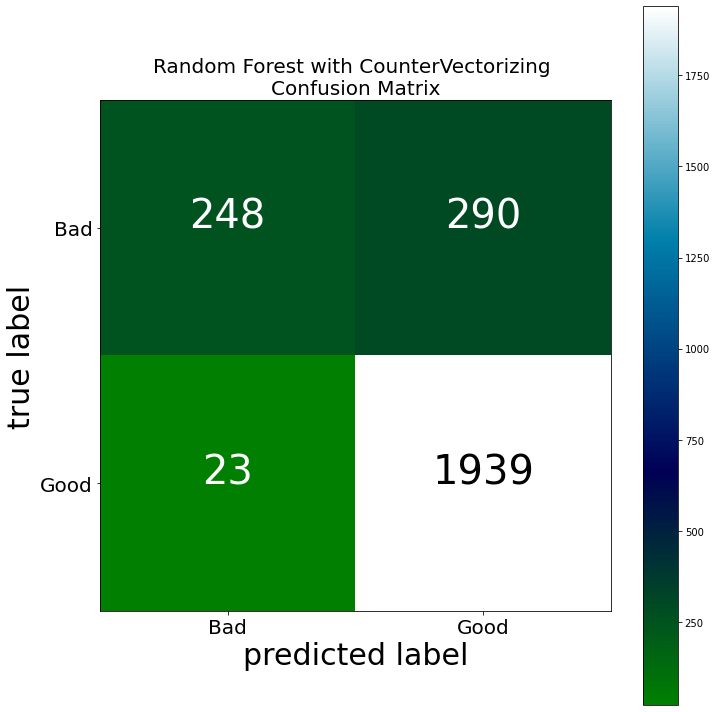

In [ ]:
# confusion matrix
disp_confusion_matrix(y_pred_cv_rf, 'Random Forest')

### Naive Bayes with CountVectorizer

In [ ]:
# modeling function for naive bays with countvectorizer and print f1 score
modeling(MultinomialNB())

y_pred_cv_nb = y_pred

f1 score: 0.875405381528768


In [ ]:
# classification report
print(classification_report(y_test, y_pred_cv_nb))

              precision    recall  f1-score   support

           0       0.82      0.59      0.68       538
           1       0.89      0.96      0.93      1962

    accuracy                           0.88      2500
   macro avg       0.86      0.78      0.81      2500
weighted avg       0.88      0.88      0.88      2500



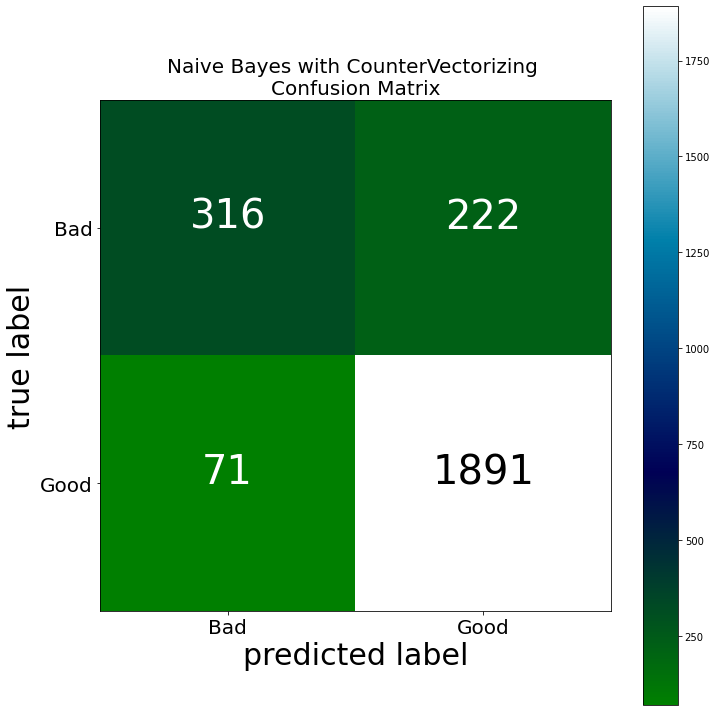

In [ ]:
# confusion matrix
disp_confusion_matrix(y_pred_cv_nb, 'Naive Bayes')

### XGBoost with CountVectorizer

In [ ]:
# modeling function for XGBoost with countvectorizer and print f1 score
modeling(XGBClassifier())

y_pred_cv_xgb = y_pred

f1 score: 0.8465358679918942


In [ ]:
# classification report
print(classification_report(y_test, y_pred_cv_xgb))

              precision    recall  f1-score   support

           0       0.75      0.51      0.60       538
           1       0.88      0.95      0.91      1962

    accuracy                           0.86      2500
   macro avg       0.81      0.73      0.76      2500
weighted avg       0.85      0.86      0.85      2500



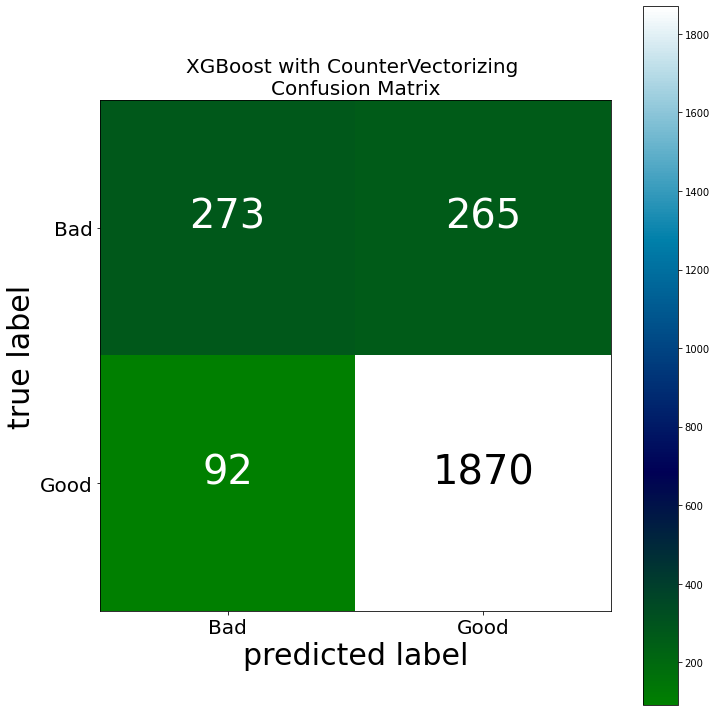

In [ ]:
# confusion matrix
disp_confusion_matrix(y_pred_cv_xgb, 'XGBoost')

### CatBoost with CountVectorizer

In [ ]:
# modeling function for catboost with countvectorizer and print f1 score
modeling(CatBoostClassifier(iterations=100, learning_rate=0.8,
                            depth=2, loss_function='Logloss'))

y_pred_cv_catboost = y_pred

0:	learn: 0.5020069	total: 84.4ms	remaining: 8.36s
1:	learn: 0.4383052	total: 110ms	remaining: 5.39s
2:	learn: 0.4069332	total: 133ms	remaining: 4.3s
3:	learn: 0.3851861	total: 157ms	remaining: 3.77s
4:	learn: 0.3721845	total: 183ms	remaining: 3.48s
5:	learn: 0.3587789	total: 207ms	remaining: 3.24s
6:	learn: 0.3505523	total: 231ms	remaining: 3.07s
7:	learn: 0.3446232	total: 255ms	remaining: 2.93s
8:	learn: 0.3348567	total: 280ms	remaining: 2.83s
9:	learn: 0.3272139	total: 313ms	remaining: 2.81s
10:	learn: 0.3209656	total: 338ms	remaining: 2.73s
11:	learn: 0.3168396	total: 364ms	remaining: 2.67s
12:	learn: 0.3124318	total: 390ms	remaining: 2.61s
13:	learn: 0.3054781	total: 415ms	remaining: 2.55s
14:	learn: 0.3021786	total: 441ms	remaining: 2.5s
15:	learn: 0.2984431	total: 467ms	remaining: 2.45s
16:	learn: 0.2952680	total: 493ms	remaining: 2.41s
17:	learn: 0.2930309	total: 523ms	remaining: 2.38s
18:	learn: 0.2907415	total: 549ms	remaining: 2.34s
19:	learn: 0.2887365	total: 576ms	remainin

In [ ]:
# classification report
print(classification_report(y_test, y_pred_cv_catboost))

              precision    recall  f1-score   support

           0       0.77      0.63      0.70       538
           1       0.90      0.95      0.93      1962

    accuracy                           0.88      2500
   macro avg       0.84      0.79      0.81      2500
weighted avg       0.88      0.88      0.88      2500



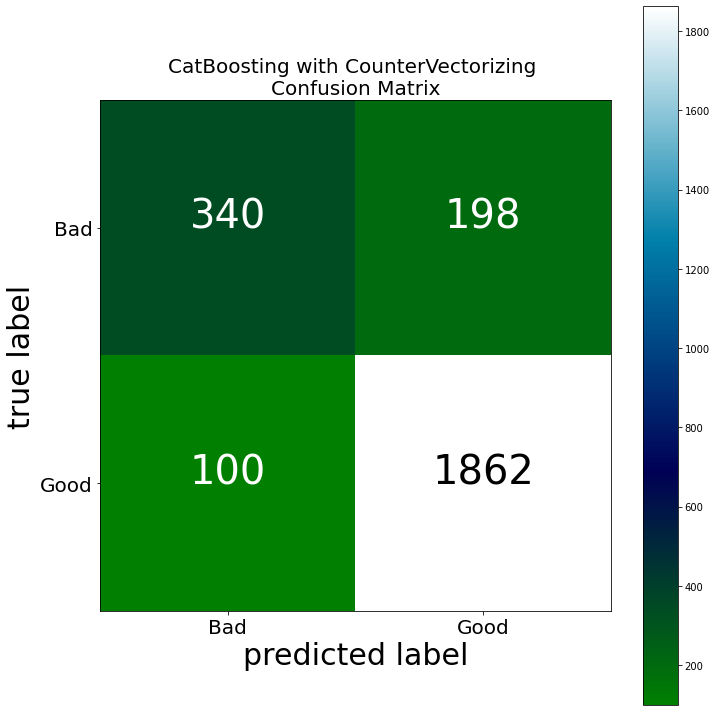

In [ ]:
# confusion matrix
disp_confusion_matrix(y_pred_cv_catboost, 'CatBoosting')

### comparison of models with CountVectorizer

In [ ]:
# function for converting the 'classification report' reseults to a dataframe
def pandas_classification_report(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred)
    avg = list(precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1_score', 'support']
    class_report_df = pd.DataFrame(list(metrics_summary), index=metrics_sum_index)
    support = class_report_df.loc['support']
    total = support.sum()
    avg[-1] = total
    class_report_df['weighted_avg'] = avg
    return class_report_df.T

In [ ]:
# function for adding explanatory columns and organizing all dataframe
def comparison_matrix(y_test, y_pred, label, vector):
    df = pandas_classification_report(y_test, y_pred)
    df['class'] = ['bad', 'good', 'average']
    df['accuracy'] = metrics.accuracy_score(y_test, y_pred)
    df['model'] = label
    df['vectorizer'] = vector
    df = df[['vectorizer', 'model', 'accuracy', 'class', 'precision', 'recall', 'f1_score', 'support']]
    return df

In [ ]:
# loop for using comparison functions
def comparison_table(y_preds, labels):

    # empty list for collecting dataframes
    frames_tv = []

    # list for y_preds
    y_preds_tv = y_preds

    # list for labels
    labels_tv = labels

    vector_tv = 'CountVect'

    for y_pred, label in zip(y_preds_tv, labels_tv):
        df = comparison_matrix(y_test, y_pred, label, vector_tv)
        frames_tv.append(df)

    # concatenating all dataframes
    global df_tv
    df_tv = pd.concat(frames_tv)

    global df_tv2
    df_tv2 = df_tv.set_index(['vectorizer', 'model', 'accuracy', 'class'])

In [ ]:
# function for f1 score plotting
def f1_score_bar_plot(df, category, title):
    df = df[df['class']==category]
    x = list(df['model'])
    y = list(df['f1_score'])
    y_round = list(round(df['f1_score'], 2))
    a = (list(df['f1_score'])).index(max(list(df['f1_score'])))
    z = (list(df['f1_score'])).index(min(list(df['f1_score'])))
    y_mean = round(df['f1_score'].mean(), 2)

    plt.rcParams['figure.figsize'] = [15, 5]
    b_plot = plt.bar(x=x, height=y)
    b_plot[a].set_color('g')
    b_plot[z].set_color('r')

    for i, v in enumerate(y_round):
        plt.text(i-.15,0.018,str(v), color='black', fontsize=15, fontweight='bold')

        plt.axhline(y_mean, ls='--', color='k', label=y_mean)
        plt.title(title)
        plt.legend()

        return plt.show()

In [ ]:
# algorithms comparison with CountVectorizer
comparison_table(y_preds = [y_pred_cv_logreg, y_pred_cv_rf, y_pred_cv_nb, y_pred_cv_xgb, y_pred_cv_catboost],
                 labels = ['LogReg', 'RandomForest', 'NaiveBayes', 'XGBoost', 'CatBoost'])

In [ ]:
df_tv2

precision  ...  support
vectorizer model        accuracy class               ...         
CountVect  LogReg       0.8812   bad       0.685100  ...    538.0
                                 good      0.950243  ...   1962.0
                                 average   0.893184  ...   2500.0
           RandomForest 0.8748   bad       0.915129  ...    538.0
                                 good      0.869897  ...   1962.0
                                 average   0.879631  ...   2500.0
           NaiveBayes   0.8828   bad       0.816537  ...    538.0
                                 good      0.894936  ...   1962.0
                                 average   0.878065  ...   2500.0
           XGBoost      0.8572   bad       0.747945  ...    538.0
                                 good      0.875878  ...   1962.0
                                 average   0.848347  ...   2500.0
           CatBoost     0.8808   bad       0.772727  ...    538.0
                                 good      0.903883  ...   1962.0
                                 average   0.875659  ...   2500.0

[15 rows x 4 columns]

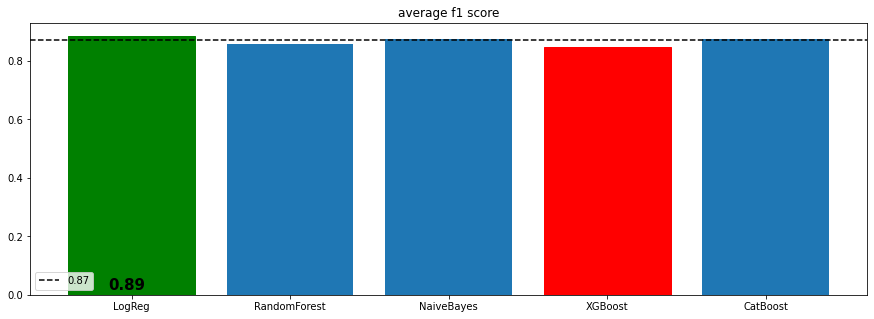

In [ ]:
# average f1 score - models with countvectorizer
# plot f1 score with f1_score_bar_plot function
f1_score_bar_plot(df=df_tv, category='average', title='average f1 score')

## TF-IDF

In [ ]:
# create the word vector with TF-IDF vectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1))
tfidf_vect_train = tfidf_vect.fit_transform(X_train)
tfidf_vect_train = tfidf_vect_train.toarray()
tfidf_vect_test = tfidf_vect.transform(X_test)
tfidf_vect_test = tfidf_vect_test.toarray()

### Logistic Regression with TF-IDF

In [ ]:
# modeling function for logistic regression with TF-IDF and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver='newton-cg',
                            class_weight='balanced', C=0.1, n_jobs=-1, random_state=42),
                            tfidf_vect_train, tfidf_vect_test)

y_pred_tfidf_logreg = y_pred

f1 score: 0.8788569573738363


In [ ]:
# classification report
print(classification_report(y_test, y_pred_tfidf_logreg))

              precision    recall  f1-score   support

           0       0.65      0.87      0.75       538
           1       0.96      0.87      0.92      1962

    accuracy                           0.87      2500
   macro avg       0.81      0.87      0.83      2500
weighted avg       0.89      0.87      0.88      2500



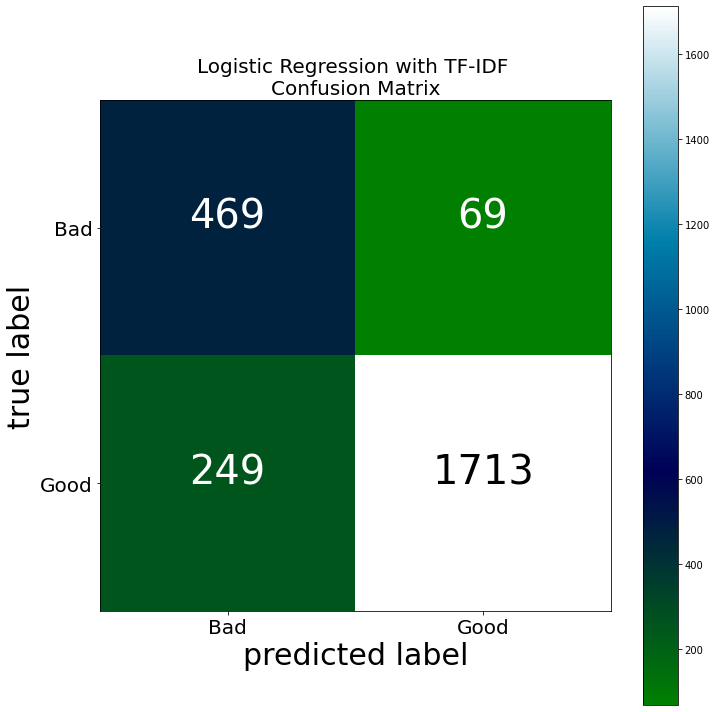

In [ ]:
# confusion matrix
disp_confusion_matrix(y_pred_tfidf_logreg, 'Logistic Regression', 'TF-IDF')

### Random Forest with TF-IDF

In [ ]:
# modeling function for random forest classifier with TF-IDF and print f1 score
modeling(RandomForestClassifier(n_estimators=200, random_state=42),
         tfidf_vect_train, tfidf_vect_test)

y_pred_tfidf_rf = y_pred

f1 score: 0.8501693322835827


In [ ]:
# classification report
print(classification_report(y_test, y_pred_tfidf_rf))

              precision    recall  f1-score   support

           0       0.87      0.45      0.59       538
           1       0.87      0.98      0.92      1962

    accuracy                           0.87      2500
   macro avg       0.87      0.72      0.76      2500
weighted avg       0.87      0.87      0.85      2500



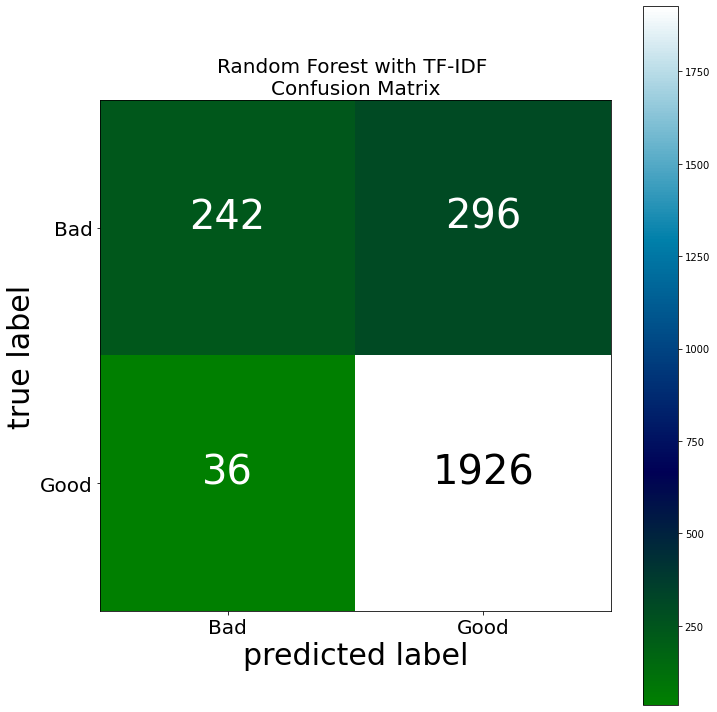

In [ ]:
# confusion matrix
disp_confusion_matrix(y_pred_tfidf_rf, 'Random Forest', 'TF-IDF')

### Naive Bayes with TF-IDF

In [ ]:
# modeling function for naive bayes with TF-IDF and print f1 score
modeling(MultinomialNB(), tfidf_vect_train, tfidf_vect_test)

y_pred_tfidf_nb = y_pred

f1 score: 0.699578003816869


In [ ]:
# classification report
print(classification_report(y_test, y_pred_tfidf_nb))

              precision    recall  f1-score   support

           0       1.00      0.02      0.04       538
           1       0.79      1.00      0.88      1962

    accuracy                           0.79      2500
   macro avg       0.89      0.51      0.46      2500
weighted avg       0.83      0.79      0.70      2500



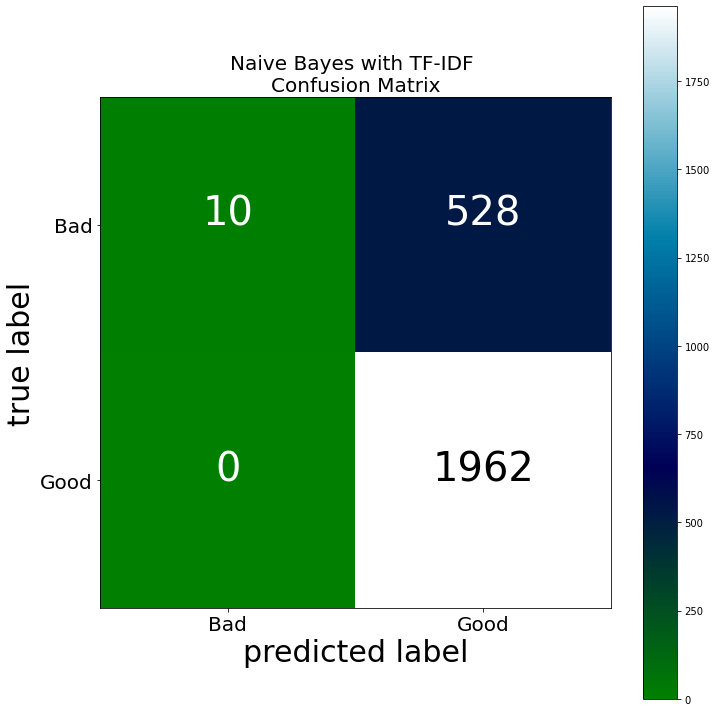

In [ ]:
# confusion matrix
disp_confusion_matrix(y_pred_tfidf_nb, 'Naive Bayes', 'TF-IDF')

### XGBoost with TF-IDF

In [ ]:
# modeling function for XGBoost with TF-IDF and print f1 score
modeling(XGBClassifier(), tfidf_vect_train, tfidf_vect_test)

y_pred_tfidf_xgb = y_pred

f1 score: 0.8525839082907384


In [ ]:
# classification report
print(classification_report(y_test, y_pred_tfidf_xgb))

              precision    recall  f1-score   support

           0       0.75      0.54      0.63       538
           1       0.88      0.95      0.91      1962

    accuracy                           0.86      2500
   macro avg       0.81      0.74      0.77      2500
weighted avg       0.85      0.86      0.85      2500



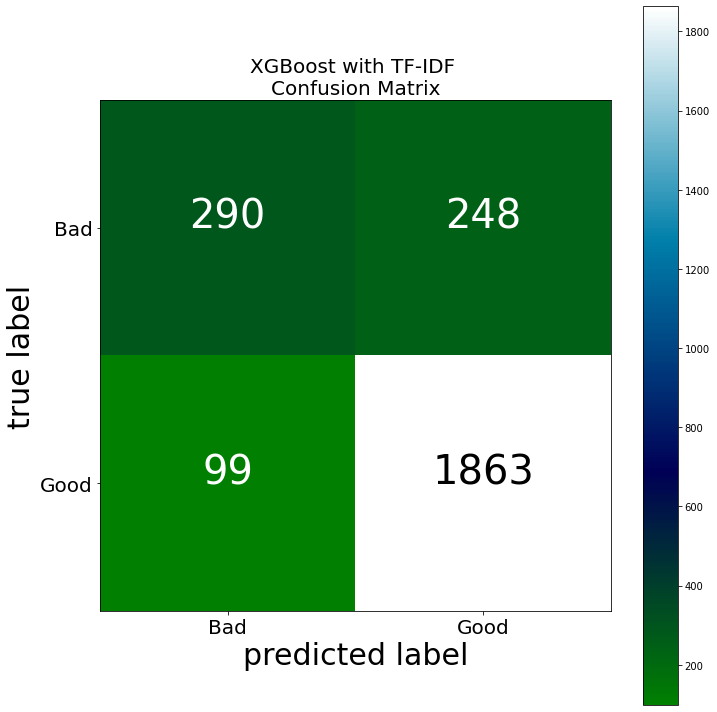

In [ ]:
# confusion matrix
disp_confusion_matrix(y_pred_tfidf_xgb, 'XGBoost', 'TF-IDF')

### Catboost with TF-IDF

In [ ]:
# modeling function for Catboost with TF-IDF and print f1 score
modeling(CatBoostClassifier(iterations=100, learning_rate=0.8, depth=2,
                            loss_function='Logloss'), tfidf_vect_train, tfidf_vect_test)

y_pred_tfidf_catboost = y_pred

0:	learn: 0.4692713	total: 79.3ms	remaining: 7.85s
1:	learn: 0.4180270	total: 136ms	remaining: 6.65s
2:	learn: 0.3935381	total: 189ms	remaining: 6.11s
3:	learn: 0.3813364	total: 254ms	remaining: 6.09s
4:	learn: 0.3668749	total: 315ms	remaining: 5.98s
5:	learn: 0.3594562	total: 370ms	remaining: 5.8s
6:	learn: 0.3528861	total: 423ms	remaining: 5.62s
7:	learn: 0.3426237	total: 481ms	remaining: 5.53s
8:	learn: 0.3328152	total: 538ms	remaining: 5.44s
9:	learn: 0.3240520	total: 595ms	remaining: 5.35s
10:	learn: 0.3162628	total: 657ms	remaining: 5.31s
11:	learn: 0.3085224	total: 719ms	remaining: 5.27s
12:	learn: 0.3035927	total: 778ms	remaining: 5.21s
13:	learn: 0.2987762	total: 839ms	remaining: 5.16s
14:	learn: 0.2958995	total: 897ms	remaining: 5.08s
15:	learn: 0.2931491	total: 951ms	remaining: 4.99s
16:	learn: 0.2908929	total: 1.01s	remaining: 4.94s
17:	learn: 0.2874982	total: 1.07s	remaining: 4.87s
18:	learn: 0.2847709	total: 1.12s	remaining: 4.79s
19:	learn: 0.2826623	total: 1.18s	remaini

In [ ]:
# classification report
print(classification_report(y_test, y_pred_tfidf_catboost))

              precision    recall  f1-score   support

           0       0.73      0.61      0.66       538
           1       0.90      0.94      0.92      1962

    accuracy                           0.87      2500
   macro avg       0.81      0.77      0.79      2500
weighted avg       0.86      0.87      0.86      2500



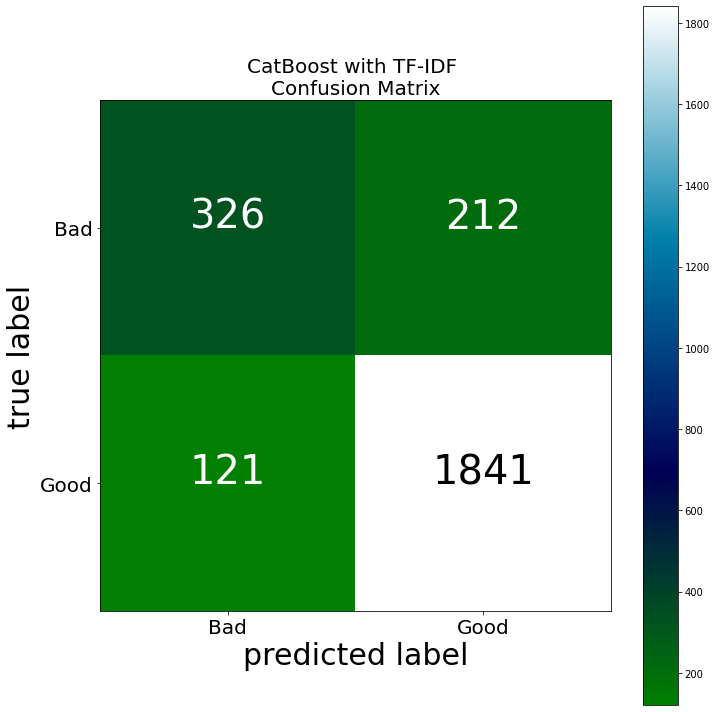

In [ ]:
# confusion matrix
disp_confusion_matrix(y_pred_tfidf_catboost, 'CatBoost', 'TF-IDF')

### Comparison of models with TF-IDF vectorizer

In [ ]:
comparison_table(y_preds = [y_pred_tfidf_logreg, y_pred_tfidf_rf, y_pred_tfidf_nb, y_pred_tfidf_xgb, y_pred_tfidf_catboost],
                 labels = ['LogReg', 'RandomForest', 'NaiveBayes', 'XGBoost', 'CatBoost'])

In [ ]:
# comparision matrix
df_tv2

precision  ...  support
vectorizer model        accuracy class               ...         
CountVect  LogReg       0.8728   bad       0.653203  ...    538.0
                                 good      0.961279  ...   1962.0
                                 average   0.894981  ...   2500.0
           RandomForest 0.8672   bad       0.870504  ...    538.0
                                 good      0.866787  ...   1962.0
                                 average   0.867587  ...   2500.0
           NaiveBayes   0.7888   bad       1.000000  ...    538.0
                                 good      0.787952  ...   1962.0
                                 average   0.833585  ...   2500.0
           XGBoost      0.8612   bad       0.745501  ...    538.0
                                 good      0.882520  ...   1962.0
                                 average   0.853034  ...   2500.0
           CatBoost     0.8668   bad       0.729306  ...    538.0
                                 good      0.896736  ...   1962.0
                                 average   0.860706  ...   2500.0

[15 rows x 4 columns]

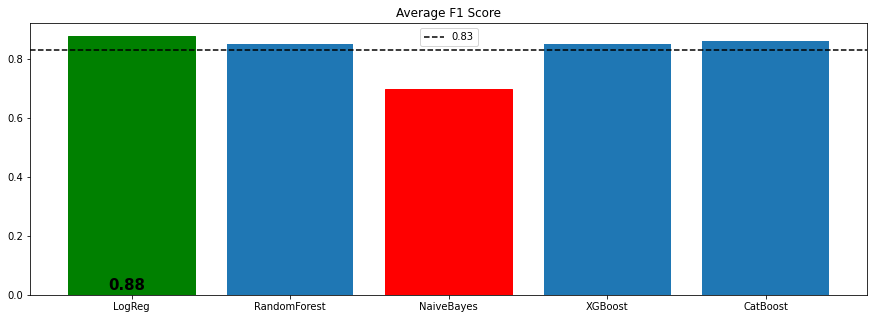

In [ ]:
# average f1 score
f1_score_bar_plot(df=df_tv, category='average', title='Average F1 Score')

## Hashing Vectorizer

In [ ]:
# create the word vector with Hash Vectorizer
hash_vect = HashingVectorizer(n_features=2000, ngram_range=(1, 1), alternate_sign=False)    # non_negative=True 지원 안함
hash_vect_train = hash_vect.fit_transform(X_train)
hash_vect_train = hash_vect_train.toarray()
hash_vect_test = hash_vect.transform(X_test)
hash_vect_test = hash_vect_test.toarray()

### Logistic Regression with Hash Vectorizer

In [ ]:
# modeling function for logistic regression with Hash Vectorizer
modeling(LogisticRegression(multi_class='multinomial', solver='newton-cg',
                            class_weight='balanced', C=0.1, n_jobs=-1, random_state=42),
         hash_vect_train, hash_vect_test)

y_pred_hash_logreg = y_pred

f1 score: 0.8415631589987821


In [ ]:
print(classification_report(y_test, y_pred_hash_logreg))

              precision    recall  f1-score   support

           0       0.58      0.82      0.68       538
           1       0.95      0.83      0.89      1962

    accuracy                           0.83      2500
   macro avg       0.76      0.83      0.78      2500
weighted avg       0.87      0.83      0.84      2500



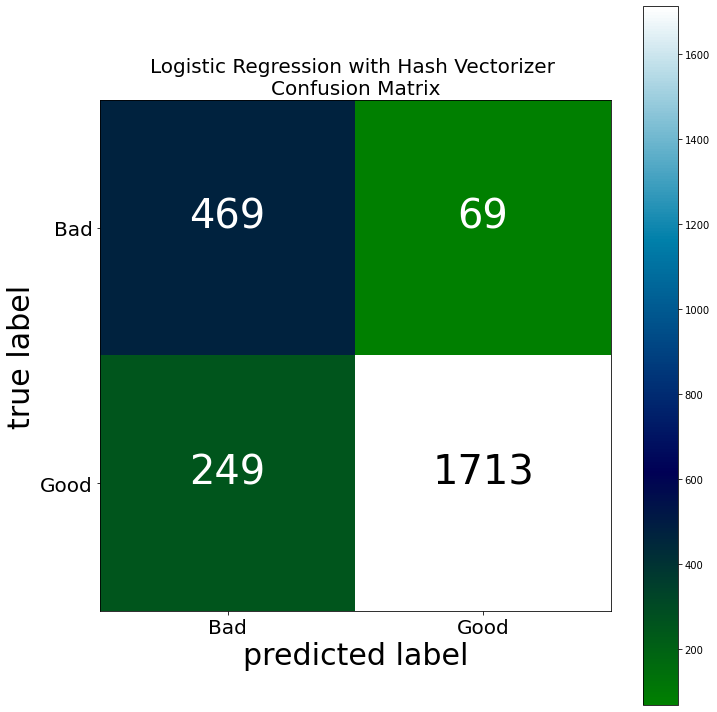

In [ ]:
disp_confusion_matrix(y_pred_tfidf_logreg, 'Logistic Regression', 'Hash Vectorizer')

### Random Forest with Hash Vectorizer

In [ ]:
modeling(RandomForestClassifier(n_estimators=200, random_state=42),
         hash_vect_train, hash_vect_test)

y_pred_hash_rf = y_pred

f1 score: 0.8335578666988654


In [ ]:
print(classification_report(y_test, y_pred_hash_rf))

              precision    recall  f1-score   support

           0       0.85      0.40      0.54       538
           1       0.86      0.98      0.91      1962

    accuracy                           0.85      2500
   macro avg       0.85      0.69      0.73      2500
weighted avg       0.85      0.85      0.83      2500



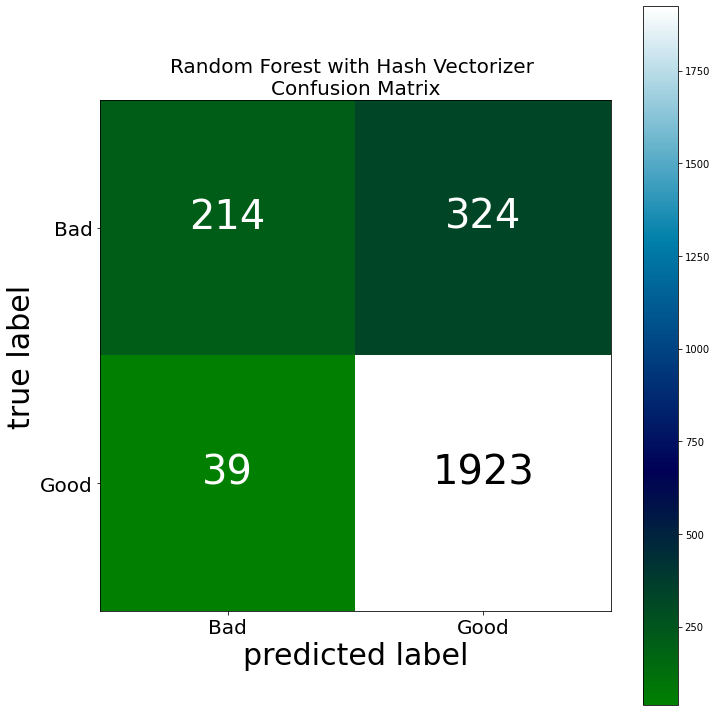

In [ ]:
disp_confusion_matrix(y_pred_hash_rf, 'Random Forest', 'Hash Vectorizer')

### Naive Bayes with Hash Vectorizer

In [ ]:
modeling(MultinomialNB(), hash_vect_train, hash_vect_test)

y_pred_hash_nb = y_pred

f1 score: 0.7327782828909088


In [ ]:
print(classification_report(y_test, y_pred_hash_nb))

              precision    recall  f1-score   support

           0       0.88      0.09      0.17       538
           1       0.80      1.00      0.89      1962

    accuracy                           0.80      2500
   macro avg       0.84      0.54      0.53      2500
weighted avg       0.82      0.80      0.73      2500



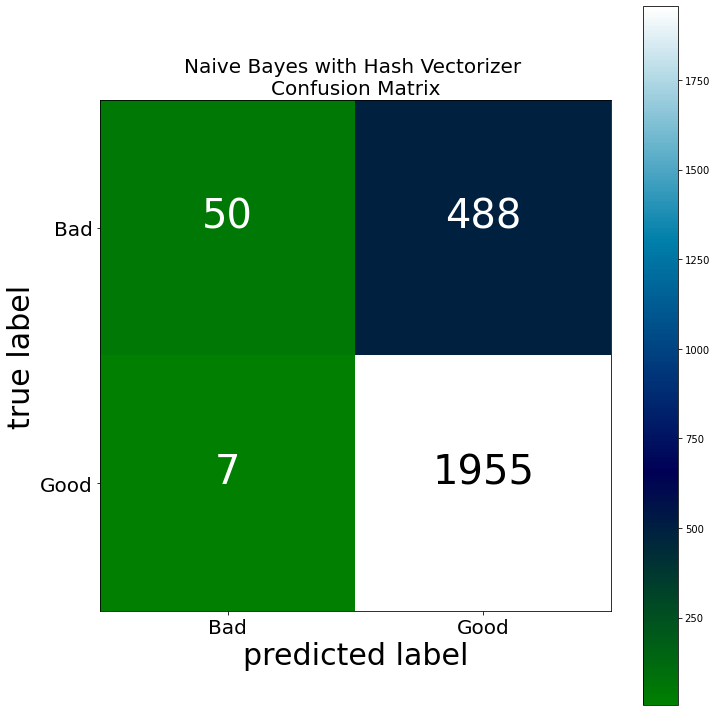

In [ ]:
disp_confusion_matrix(y_pred_hash_nb, 'Naive Bayes', 'Hash Vectorizer')

### XGBoost with Hash Vectorize

In [ ]:
modeling(XGBClassifier(), hash_vect_train, hash_vect_test)

y_pred_hash_xgb = y_pred

f1 score: 0.8442589408649602


In [ ]:
print(classification_report(y_test, y_pred_hash_xgb))

              precision    recall  f1-score   support

           0       0.76      0.49      0.59       538
           1       0.87      0.96      0.91      1962

    accuracy                           0.86      2500
   macro avg       0.82      0.72      0.75      2500
weighted avg       0.85      0.86      0.84      2500



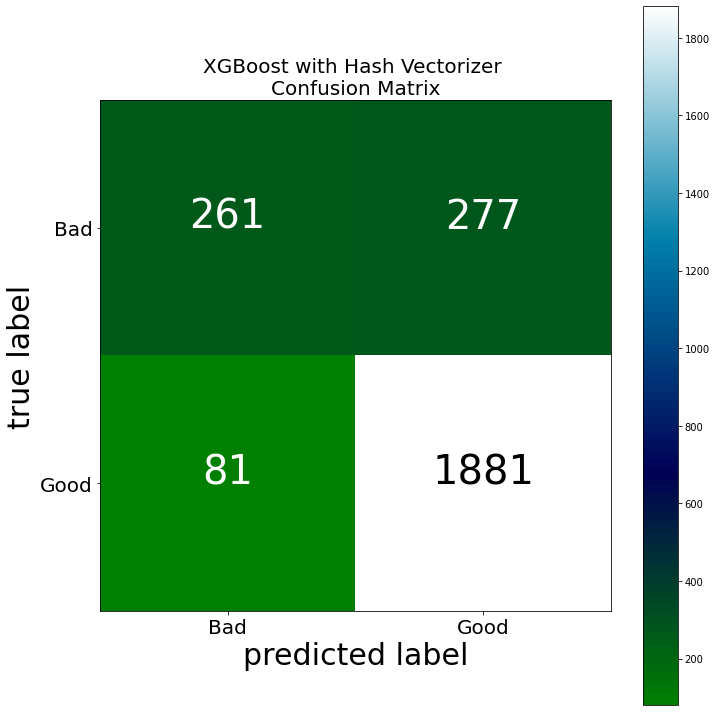

In [ ]:
disp_confusion_matrix(y_pred_hash_xgb, 'XGBoost', 'Hash Vectorizer')

### CatBoost with Hash Vectorizer

In [ ]:
modeling(CatBoostClassifier(iterations=100, learning_rate=0.8, depth=2,
                            loss_function='Logloss'), hash_vect_train, hash_vect_test)

y_pred_hash_catboost = y_pred

0:	learn: 0.4869306	total: 44.8ms	remaining: 4.43s
1:	learn: 0.4556379	total: 80.9ms	remaining: 3.96s
2:	learn: 0.4248796	total: 119ms	remaining: 3.86s
3:	learn: 0.4048091	total: 157ms	remaining: 3.77s
4:	learn: 0.3928372	total: 194ms	remaining: 3.68s
5:	learn: 0.3840657	total: 238ms	remaining: 3.73s
6:	learn: 0.3779571	total: 283ms	remaining: 3.76s
7:	learn: 0.3693378	total: 323ms	remaining: 3.71s
8:	learn: 0.3567679	total: 361ms	remaining: 3.65s
9:	learn: 0.3489545	total: 397ms	remaining: 3.57s
10:	learn: 0.3461822	total: 436ms	remaining: 3.52s
11:	learn: 0.3393829	total: 473ms	remaining: 3.47s
12:	learn: 0.3353280	total: 514ms	remaining: 3.44s
13:	learn: 0.3298162	total: 553ms	remaining: 3.4s
14:	learn: 0.3251342	total: 589ms	remaining: 3.34s
15:	learn: 0.3223702	total: 626ms	remaining: 3.29s
16:	learn: 0.3177881	total: 663ms	remaining: 3.24s
17:	learn: 0.3154208	total: 700ms	remaining: 3.19s
18:	learn: 0.3115766	total: 741ms	remaining: 3.16s
19:	learn: 0.3085107	total: 779ms	remain

In [ ]:
print(classification_report(y_test, y_pred_hash_catboost))

              precision    recall  f1-score   support

           0       0.72      0.62      0.67       538
           1       0.90      0.93      0.92      1962

    accuracy                           0.87      2500
   macro avg       0.81      0.78      0.79      2500
weighted avg       0.86      0.87      0.86      2500



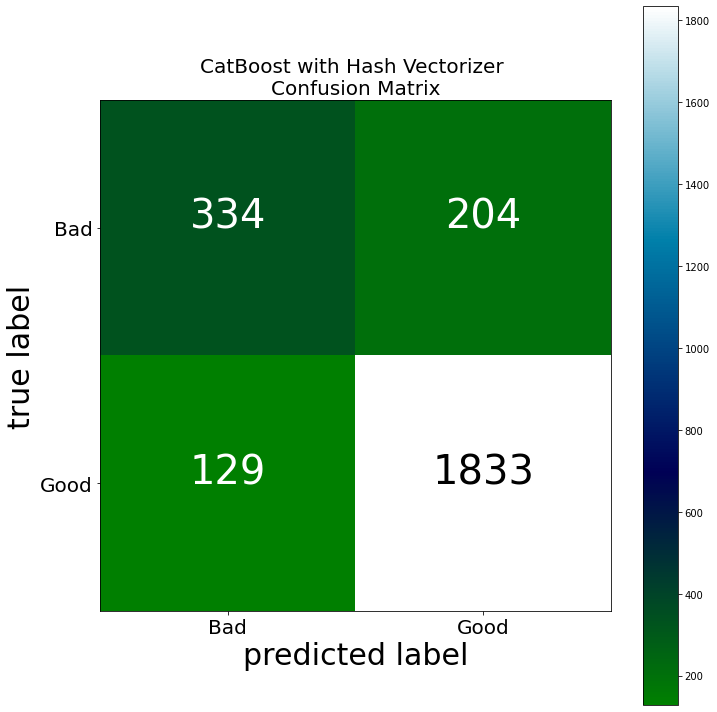

In [ ]:
disp_confusion_matrix(y_pred_hash_catboost, 'CatBoost', 'Hash Vectorizer')

### Comparison of Models with Hash Vectorizer

In [ ]:
comparison_table(y_preds = [y_pred_hash_logreg, y_pred_hash_rf, y_pred_hash_nb, y_pred_hash_xgb, y_pred_hash_catboost], 
                labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost', 'CatBoost'])

In [ ]:
df_tv2

precision  ...  support
vectorizer model         accuracy class               ...         
CountVect  LogReg        0.8320   bad       0.576823  ...    538.0
                                  good      0.945150  ...   1962.0
                                  average   0.865886  ...   2500.0
           Random Forest 0.8548   bad       0.845850  ...    538.0
                                  good      0.855808  ...   1962.0
                                  average   0.853665  ...   2500.0
           Naive Bayes   0.8020   bad       0.877193  ...    538.0
                                  good      0.800246  ...   1962.0
                                  average   0.816805  ...   2500.0
           XGBoost       0.8568   bad       0.763158  ...    538.0
                                  good      0.871640  ...   1962.0
                                  average   0.848295  ...   2500.0
           CatBoost      0.8668   bad       0.721382  ...    538.0
                                  good      0.899853  ...   1962.0
                                  average   0.861446  ...   2500.0

[15 rows x 4 columns]

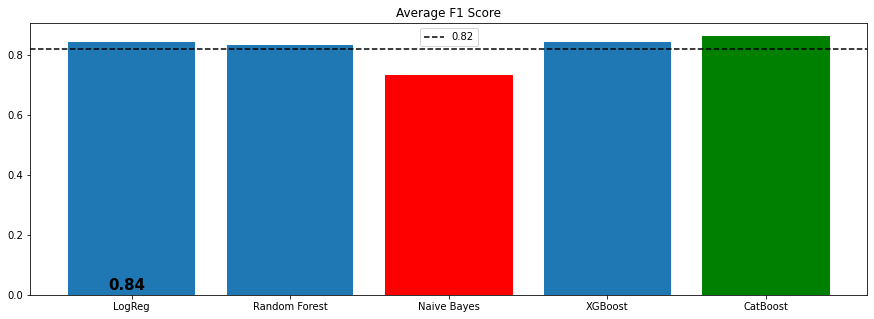

In [ ]:
f1_score_bar_plot(df=df_tv, category='average', title='Average F1 Score')